Useful conversation: https://claude.ai/chat/f757fbe0-99f4-4386-9601-de508a4ad71d

In [1]:
import json
from collections import Counter
import difflib
import glob
import os
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# Initialize an empty list to hold all question-answer pairs
combined_data = []

# For each JSON file output from Gemini - automatically find all parts
json_files = glob.glob("/Users/joelswenson/Documents/Adas_spark/code_repo/github_repo__called_code/first_pass_generated_qa_pairs_with_problems/generated_qa_pairs_part*.json")
json_files.sort()  # Ensure consistent ordering (part1, part2, etc.)

print(f"Found {len(json_files)} JSON files: {json_files}")

Found 15 JSON files: ['/Users/joelswenson/Documents/Adas_spark/code_repo/github_repo__called_code/first_pass_generated_qa_pairs_with_problems/generated_qa_pairs_part1.json', '/Users/joelswenson/Documents/Adas_spark/code_repo/github_repo__called_code/first_pass_generated_qa_pairs_with_problems/generated_qa_pairs_part10.json', '/Users/joelswenson/Documents/Adas_spark/code_repo/github_repo__called_code/first_pass_generated_qa_pairs_with_problems/generated_qa_pairs_part11.json', '/Users/joelswenson/Documents/Adas_spark/code_repo/github_repo__called_code/first_pass_generated_qa_pairs_with_problems/generated_qa_pairs_part12.json', '/Users/joelswenson/Documents/Adas_spark/code_repo/github_repo__called_code/first_pass_generated_qa_pairs_with_problems/generated_qa_pairs_part13.json', '/Users/joelswenson/Documents/Adas_spark/code_repo/github_repo__called_code/first_pass_generated_qa_pairs_with_problems/generated_qa_pairs_part14.json', '/Users/joelswenson/Documents/Adas_spark/code_repo/github_rep

In [3]:
def fix_json_file(file_path):
    """Robust JSON fixing for common Gemini output issues"""
    import re
    
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    
    # Fix 1: Escape unescaped quotes in answer_text fields
    def fix_answer_text(match):
        full_match = match.group(0)
        text_content = match.group(1)
        
        # Temporarily replace already escaped quotes
        text_content = text_content.replace('\\"', '___ESCAPED_QUOTE___')
        # Escape remaining quotes
        text_content = text_content.replace('"', '\\"')
        # Restore the escaped quotes
        text_content = text_content.replace('___ESCAPED_QUOTE___', '\\"')
        
        return f'"answer_text": "{text_content}"'
    
    # Apply the fix to answer_text fields
    content = re.sub(r'"answer_text":\s*"(.*?)"(?=\s*,\s*"source_post_id")', 
                     fix_answer_text, content, flags=re.DOTALL)
    
    # Fix 2: Remove any trailing commas before closing brackets
    content = re.sub(r',\s*}', '}', content)
    content = re.sub(r',\s*]', ']', content)
    
    # Fix 3: Ensure proper JSON array structure
    if not content.strip().startswith('['):
        content = '[' + content
    if not content.strip().endswith(']'):
        content = content + ']'
    
    # Write fixed content
    fixed_path = file_path + '.fixed'
    with open(fixed_path, 'w', encoding='utf-8') as file:
        file.write(content)
    
    return fixed_path

In [4]:
# Combine all the relevant jsons into a single data structure
for file_path in json_files:
    try:
        print(f"Processing {file_path}...")
        with open(file_path, 'r') as file:
            batch_data = json.load(file)
            print(f"  ✓ Successfully loaded {len(batch_data)} Q&A pairs")
            # Append this batch's data to our combined list
            combined_data.extend(batch_data)
    except json.JSONDecodeError as e:
        print(f"  ✗ JSON Error in {file_path} - attempting to fix...")
        
        # Try to fix the JSON formatting issues
        try:
            fixed_file_path = fix_json_file(file_path)
            with open(fixed_file_path, 'r') as file:
                batch_data = json.load(file)
                print(f"  ✓ Fixed and loaded {len(batch_data)} Q&A pairs")
                combined_data.extend(batch_data)
                
            # Remove the temporary fixed file
            os.remove(fixed_file_path)
            
        except Exception as fix_error:
            print(f"  ✗ Could not fix {file_path}: {fix_error}")
            print(f"    Original error - Line {e.lineno}, Column {e.colno}: {e.msg}")
            continue

Processing /Users/joelswenson/Documents/Adas_spark/code_repo/github_repo__called_code/first_pass_generated_qa_pairs_with_problems/generated_qa_pairs_part1.json...
  ✗ JSON Error in /Users/joelswenson/Documents/Adas_spark/code_repo/github_repo__called_code/first_pass_generated_qa_pairs_with_problems/generated_qa_pairs_part1.json - attempting to fix...
  ✓ Fixed and loaded 10 Q&A pairs
Processing /Users/joelswenson/Documents/Adas_spark/code_repo/github_repo__called_code/first_pass_generated_qa_pairs_with_problems/generated_qa_pairs_part10.json...
  ✗ JSON Error in /Users/joelswenson/Documents/Adas_spark/code_repo/github_repo__called_code/first_pass_generated_qa_pairs_with_problems/generated_qa_pairs_part10.json - attempting to fix...
  ✓ Fixed and loaded 25 Q&A pairs
Processing /Users/joelswenson/Documents/Adas_spark/code_repo/github_repo__called_code/first_pass_generated_qa_pairs_with_problems/generated_qa_pairs_part11.json...
  ✗ JSON Error in /Users/joelswenson/Documents/Adas_spark/co

In [5]:
def reassign_question_ids(data):
    """Reassign question and answer IDs to ensure uniqueness and sequential numbering"""
    for i, qa_pair in enumerate(data):
        qa_pair["question_id"] = f"Q{i+1}"
        # Also update answer_ids if needed
        for j, answer in enumerate(qa_pair["answers"]):
            answer["answer_id"] = f"Q{i+1}A{j+1}"
    print(f"✅ Reassigned IDs for {len(data)} questions")

In [6]:
# Initial ID assignment (will be redone after cleaning)
reassign_question_ids(combined_data)

✅ Reassigned IDs for 446 questions


In [7]:
# Note: Will save combined data after QC and cleaning steps
print(f"✅ Successfully merged {len(combined_data)} Q&A pairs from {len(json_files)} files")

✅ Successfully merged 446 Q&A pairs from 15 files


In [8]:
def check_questions_coverage(combined_data, questions_file_path="../../questions_to_answer_txts/questions_to_answer.txt"):
    """
    Check which questions from the original list were actually answered.
    
    Returns:
        dict: Coverage analysis results including missing questions and metrics
    """
    # Read the original questions
    with open(questions_file_path, 'r', encoding='utf-8') as file:
        original_questions = [line.strip() for line in file if line.strip()]
    
    # Get answered questions from combined data
    answered_questions = [qa["question_text"] for qa in combined_data]
    
    # Find missing questions
    missing_questions = []
    for orig_q in original_questions:
        if orig_q not in answered_questions:
            missing_questions.append(orig_q)
    
    # Calculate metrics
    coverage_rate = (len(original_questions) - len(missing_questions)) / len(original_questions)
    
    results = {
        "original_count": len(original_questions),
        "answered_count": len(answered_questions),
        "missing_count": len(missing_questions),
        "missing_questions": missing_questions,
        "coverage_rate": coverage_rate
    }
    
    # Print summary
    print(f"\nQuestion Coverage Analysis:")
    print(f"Original questions: {results['original_count']}")
    print(f"Answered questions: {results['answered_count']}")
    print(f"Missing questions: {results['missing_count']}")
    print(f"Coverage rate: {results['coverage_rate']*100:.1f}%")
    
    return results

In [9]:
def analyze_answer_distribution(combined_data):
    """
    Analyze how many answers each question has and provide distribution statistics.
    
    Returns:
        dict: Distribution analysis including max answers and count frequencies
    """
    # Count answers per question
    answers_per_question = [len(qa["answers"]) for qa in combined_data]
    
    # Find max number of answers
    max_answers = max(answers_per_question) if answers_per_question else 0
    
    # Count frequency of each answer count (0 to max)
    answer_distribution = {}
    for n in range(0, max_answers + 1):
        count = answers_per_question.count(n)
        if count > 0:  # Only include counts that actually exist
            answer_distribution[n] = count
    
    # Calculate some summary stats
    total_questions = len(combined_data)
    avg_answers = sum(answers_per_question) / total_questions if total_questions > 0 else 0
    
    results = {
        "total_questions": total_questions,
        "max_answers_per_question": max_answers,
        "average_answers_per_question": round(avg_answers, 2),
        "answer_distribution": answer_distribution
    }
    
    # Print summary
    print(f"\nAnswer Distribution Analysis:")
    print(f"Total questions: {total_questions}")
    print(f"Average answers per question: {avg_answers:.2f}")
    print(f"Maximum answers for any question: {max_answers}")
    print(f"\nDistribution:")
    for n_answers in sorted(answer_distribution.keys()):
        count = answer_distribution[n_answers]
        percentage = (count / total_questions) * 100
        print(f"  {n_answers} answers: {count} questions ({percentage:.1f}%)")
    
    return results

In [10]:
def analyze_answer_lengths(combined_data, min_word_threshold=20, min_char_threshold=100):
    """
    Analyze the length distribution of all answers and flag short ones.
    
    Args:
        combined_data: The Q&A dataset
        min_word_threshold: Minimum words to not be flagged as "too short"
        min_char_threshold: Minimum characters to not be flagged as "too short"
    
    Returns:
        dict: Length analysis including distribution and flagged short answers
    """
    all_answers = []
    short_answers = []
    
    # Extract all answers with metadata
    for qa in combined_data:
        for answer in qa["answers"]:
            answer_text = answer["answer_text"]
            word_count = len(answer_text.split())
            char_count = len(answer_text)
            
            answer_info = {
                "question_id": qa["question_id"],
                "answer_id": answer["answer_id"],
                "word_count": word_count,
                "char_count": char_count,
                "text_preview": answer_text[:100] + "..." if len(answer_text) > 100 else answer_text
            }
            
            all_answers.append(answer_info)
            
            # Flag if too short
            if word_count < min_word_threshold or char_count < min_char_threshold:
                short_answers.append(answer_info)
    
    # Calculate statistics
    word_counts = [a["word_count"] for a in all_answers]
    char_counts = [a["char_count"] for a in all_answers]
    
    results = {
        "total_answers": len(all_answers),
        "short_answers_count": len(short_answers),
        "short_answers": short_answers,
        "word_stats": {
            "average": round(sum(word_counts) / len(word_counts), 1) if word_counts else 0,
            "min": min(word_counts) if word_counts else 0,
            "max": max(word_counts) if word_counts else 0
        },
        "char_stats": {
            "average": round(sum(char_counts) / len(char_counts), 1) if char_counts else 0,
            "min": min(char_counts) if char_counts else 0,
            "max": max(char_counts) if char_counts else 0
        },
        "thresholds": {
            "min_words": min_word_threshold,
            "min_chars": min_char_threshold
        }
    }
    
    # Print summary
    print(f"\nAnswer Length Analysis:")
    print(f"Total answers: {results['total_answers']}")
    print(f"Average length: {results['word_stats']['average']} words, {results['char_stats']['average']} characters")
    print(f"Range: {results['word_stats']['min']}-{results['word_stats']['max']} words")
    print(f"Short answers flagged: {results['short_answers_count']} ({(results['short_answers_count']/results['total_answers']*100):.1f}%)")
    
    if short_answers:
        print(f"\nFirst 5 short answers:")
        for i, answer in enumerate(short_answers[:5]):
            print(f"  {answer['answer_id']}: {answer['word_count']} words - \"{answer['text_preview']}\"")
    
    return results

In [11]:
def check_duplicate_questions(json_data):
    """Check for exact duplicate questions"""
    questions = [qa["question_text"] for qa in json_data]
    question_counts = Counter(questions)
    duplicates = [q for q, count in question_counts.items() if count > 1]
    
    results = {
        "duplicates_found": len(duplicates) > 0,
        "duplicate_questions": duplicates,
        "duplicate_details": {q: question_counts[q] for q in duplicates}
    }
    
    # Print results
    print(f"\nDuplicate Questions Check:")
    if results["duplicates_found"]:
        print(f"⚠️  Found {len(duplicates)} duplicate questions")
        for q in duplicates[:3]:  # Show first 3
            print(f"  - '{q}' (appears {question_counts[q]} times)")
        if len(duplicates) > 3:
            print(f"  ... and {len(duplicates) - 3} more")
    else:
        print("✅ No duplicate questions found")
    
    return results

In [12]:
def check_empty_answers(json_data):
    """Check for questions with no answers or empty answer arrays"""
    empty_answers = []
    
    for i, qa in enumerate(json_data):
        if "answers" not in qa or not qa["answers"] or len(qa["answers"]) == 0:
            empty_answers.append({
                "index": i,
                "question_id": qa.get("question_id", "MISSING_ID"),
                "question_text": qa.get("question_text", "MISSING_TEXT")
            })
    
    results = {
        "empty_answers_found": len(empty_answers) > 0,
        "empty_answers": empty_answers,
        "count": len(empty_answers)
    }
    
    # Print results
    print(f"\nEmpty Answers Check:")
    if results["empty_answers_found"]:
        print(f"⚠️  Found {len(empty_answers)} questions with no answers")
        for qa in empty_answers[:3]:  # Show first 3
            print(f"  - {qa['question_id']}: '{qa['question_text'][:60]}...'")
        if len(empty_answers) > 3:
            print(f"  ... and {len(empty_answers) - 3} more")
    else:
        print("✅ All questions have answers")
    
    return results

In [13]:
def check_json_format(json_data):
    """Check for JSON format consistency"""
    expected_fields = {"question_id", "question_text", "category", "answers"}
    expected_answer_fields = {"answer_id", "answer_text", "source_post_id", "source_date"}
    format_issues = []
    
    for i, qa in enumerate(json_data):
        missing_fields = expected_fields - set(qa.keys())
        if missing_fields:
            format_issues.append({
                "index": i,
                "question_id": qa.get("question_id", "MISSING_ID"),
                "issue": f"Missing fields: {', '.join(missing_fields)}"
            })
        
        if "answers" in qa and qa["answers"]:
            for j, answer in enumerate(qa["answers"]):
                missing_answer_fields = expected_answer_fields - set(answer.keys())
                if missing_answer_fields:
                    format_issues.append({
                        "index": i,
                        "question_id": qa.get("question_id", "MISSING_ID"),
                        "answer_index": j,
                        "issue": f"Answer missing fields: {', '.join(missing_answer_fields)}"
                    })
    
    results = {
        "format_issues_found": len(format_issues) > 0,
        "format_issues": format_issues,
        "count": len(format_issues)
    }
    
    # Print results
    print(f"\nJSON Format Check:")
    if results["format_issues_found"]:
        print(f"⚠️  Found {len(format_issues)} JSON format issues")
        for issue in format_issues[:3]:  # Show first 3
            print(f"  - {issue['question_id']}: {issue['issue']}")
        if len(format_issues) > 3:
            print(f"  ... and {len(format_issues) - 3} more")
    else:
        print("✅ All JSON formatting is correct")
    
    return results

In [14]:
def remove_empty_answers(data, empty_results):
    """Remove questions that have no answers based on QC results"""
    if not empty_results["empty_answers_found"]:
        print("✅ No empty answers to remove")
        return data
    
    print(f"🧹 Removing {empty_results['count']} questions with no answers...")
    
    # Get list of question IDs to remove
    question_ids_to_remove = {qa["question_id"] for qa in empty_results["empty_answers"]}
    
    # Filter out the problematic questions
    cleaned_data = [qa for qa in data if qa.get("question_id") not in question_ids_to_remove]
    
    print(f"  ✓ Removed {len(data) - len(cleaned_data)} questions")
    return cleaned_data

In [15]:
def merge_duplicate_questions(data, duplicate_results):
    """Merge answers from duplicate questions based on QC results"""
    if not duplicate_results["duplicates_found"]:
        print("✅ No duplicate questions to merge")
        return data
    
    print(f"🧹 Merging {len(duplicate_results['duplicate_questions'])} duplicate questions...")
    
    # Create a map to track merged questions
    question_map = {}
    cleaned_data = []
    
    for qa_pair in data:
        question_text = qa_pair.get("question_text", "").strip()
        
        if question_text in question_map:
            # This is a duplicate - merge its answers
            existing_qa = question_map[question_text]
            existing_answer_texts = {a["answer_text"] for a in existing_qa["answers"]}
            
            unique_answers_added = 0
            for new_answer in qa_pair.get("answers", []):
                if new_answer["answer_text"] not in existing_answer_texts:
                    existing_qa["answers"].append(new_answer)
                    existing_answer_texts.add(new_answer["answer_text"])
                    unique_answers_added += 1
            
            if unique_answers_added > 0:
                print(f"  ✓ Added {unique_answers_added} unique answers to: '{question_text[:60]}...'")
        else:
            # First time seeing this question
            question_map[question_text] = qa_pair
            cleaned_data.append(qa_pair)
    
    print(f"  ✓ Merged duplicates, {len(cleaned_data)} unique questions remain")
    return cleaned_data

In [16]:
def visualize_answer_distribution(answer_dist_results):
    """Create histogram of answers per question"""
    distribution = answer_dist_results["answer_distribution"]
    
    # Extract data for plotting
    answer_counts = list(distribution.keys())
    question_counts = list(distribution.values())
    
    plt.figure(figsize=(8, 6))
    plt.bar(answer_counts, question_counts, color='skyblue', edgecolor='navy', alpha=0.7)
    plt.xlabel('Number of Answers per Question')
    plt.ylabel('Number of Questions')
    plt.title('Distribution of Answers per Question')
    plt.xticks(answer_counts)  # Show all x-axis values
    
    # Add value labels on bars
    for i, v in enumerate(question_counts):
        plt.text(answer_counts[i], v + 0.5, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [17]:
def visualize_answer_lengths(length_results):
    """Create histogram of answer word counts"""
    # We need to extract individual word counts from combined_data
    # This function will be called right after length analysis
    word_counts = []
    for qa in combined_data:
        for answer in qa["answers"]:
            word_count = len(answer["answer_text"].split())
            word_counts.append(word_count)
    
    plt.figure(figsize=(10, 6))
    plt.hist(word_counts, bins=20, color='lightcoral', edgecolor='darkred', alpha=0.7)
    plt.xlabel('Word Count per Answer')
    plt.ylabel('Number of Answers')
    plt.title('Distribution of Answer Lengths (Word Count)')
    plt.axvline(x=20, color='red', linestyle='--', label='Minimum threshold (20 words)')
    plt.axvline(x=length_results["word_stats"]["average"], color='green', linestyle='--', 
                label=f'Average ({length_results["word_stats"]["average"]} words)')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [18]:
def save_qc_report(coverage_results, answer_dist_results, length_results, 
                   duplicate_results, empty_results, format_results, 
                   filename=None):
    """Save comprehensive QC report in human-readable format"""
    
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"ada_qa_qc_report_{timestamp}.txt"
    
    with open(filename, 'w', encoding='utf-8') as f:
        f.write("=" * 60 + "\n")
        f.write("ADA'S SPARK MEMORY ENGINE - QUALITY CONTROL REPORT\n")
        f.write("=" * 60 + "\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        # Coverage Summary
        f.write("1. QUESTION COVERAGE\n")
        f.write("-" * 20 + "\n")
        f.write(f"Original questions: {coverage_results['original_count']}\n")
        f.write(f"Answered questions: {coverage_results['answered_count']}\n")
        f.write(f"Missing questions: {coverage_results['missing_count']}\n")
        f.write(f"Coverage rate: {coverage_results['coverage_rate']*100:.1f}%\n\n")
        
        # Answer Distribution
        f.write("2. ANSWER DISTRIBUTION\n")
        f.write("-" * 20 + "\n")
        f.write(f"Total questions: {answer_dist_results['total_questions']}\n")
        f.write(f"Average answers per question: {answer_dist_results['average_answers_per_question']}\n")
        f.write(f"Max answers per question: {answer_dist_results['max_answers_per_question']}\n")
        f.write("Distribution breakdown:\n")
        for n_answers in sorted(answer_dist_results['answer_distribution'].keys()):
            count = answer_dist_results['answer_distribution'][n_answers]
            pct = (count / answer_dist_results['total_questions']) * 100
            f.write(f"  {n_answers} answers: {count} questions ({pct:.1f}%)\n")
        f.write("\n")
        
        # Length Analysis
        f.write("3. ANSWER LENGTH ANALYSIS\n")
        f.write("-" * 25 + "\n")
        f.write(f"Total answers: {length_results['total_answers']}\n")
        f.write(f"Average length: {length_results['word_stats']['average']} words\n")
        f.write(f"Length range: {length_results['word_stats']['min']}-{length_results['word_stats']['max']} words\n")
        f.write(f"Short answers flagged: {length_results['short_answers_count']} ({(length_results['short_answers_count']/length_results['total_answers']*100):.1f}%)\n")
        
        if length_results['short_answers']:
            f.write("\nShort answers:\n")
            for answer in length_results['short_answers'][:10]:  # First 10
                f.write(f"  {answer['answer_id']}: {answer['word_count']} words\n")
        f.write("\n")
        
        # Quality Checks
        f.write("4. QUALITY CHECKS\n")
        f.write("-" * 15 + "\n")
        
        # Duplicates
        f.write("Duplicate Questions: ")
        if duplicate_results['duplicates_found']:
            f.write(f"❌ {len(duplicate_results['duplicate_questions'])} found\n")
            for q in duplicate_results['duplicate_questions'][:5]:
                f.write(f"  - {q}\n")
        else:
            f.write("✅ None found\n")
        
        # Empty answers
        f.write("Empty Answers: ")
        if empty_results['empty_answers_found']:
            f.write(f"❌ {empty_results['count']} found\n")
        else:
            f.write("✅ None found\n")
        
        # Format issues
        f.write("Format Issues: ")
        if format_results['format_issues_found']:
            f.write(f"❌ {format_results['count']} found\n")
        else:
            f.write("✅ None found\n")
        
        f.write("\n" + "=" * 60 + "\n")
        f.write("END OF REPORT\n")
        f.write("=" * 60 + "\n")
    
    print(f"✅ QC report saved to: {filename}")
    return filename

RUNNING QC CHECKS AND DATA CLEANING

1️⃣ INITIAL QUALITY CHECKS

Empty Answers Check:
⚠️  Found 4 questions with no answers
  - Q11: 'What was Ada’s favorite meal?...'
  - Q25: 'Share a story about Ada's leadership among her daycare peers...'
  - Q142: 'Did Ada have a favorite book or story that inspired her imag...'
  ... and 1 more

Duplicate Questions Check:
⚠️  Found 10 duplicate questions
  - 'Tell me a funny story about Ada.' (appears 2 times)
  - 'What was something Ada said that made everyone laugh?' (appears 2 times)
  - 'Can you share a humorous anecdote involving Ada and her siblings?' (appears 2 times)
  ... and 7 more

JSON Format Check:
✅ All JSON formatting is correct

2️⃣ DATA CLEANING
🧹 Removing 4 questions with no answers...
  ✓ Removed 4 questions
🧹 Merging 10 duplicate questions...
  ✓ Merged duplicates, 432 unique questions remain

3️⃣ REASSIGNING IDS AFTER CLEANING
✅ Reassigned IDs for 432 questions

4️⃣ FINAL QUALITY CHECKS

Question Coverage Analysis:
Original q

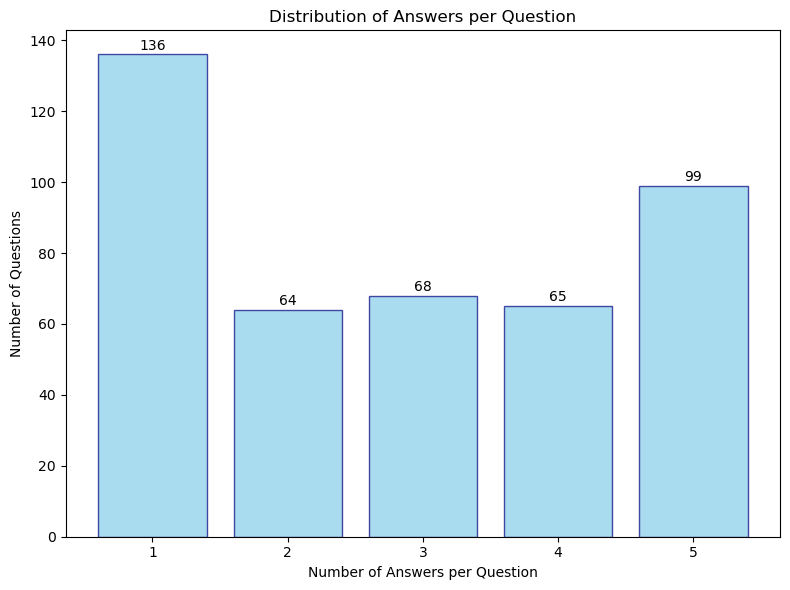

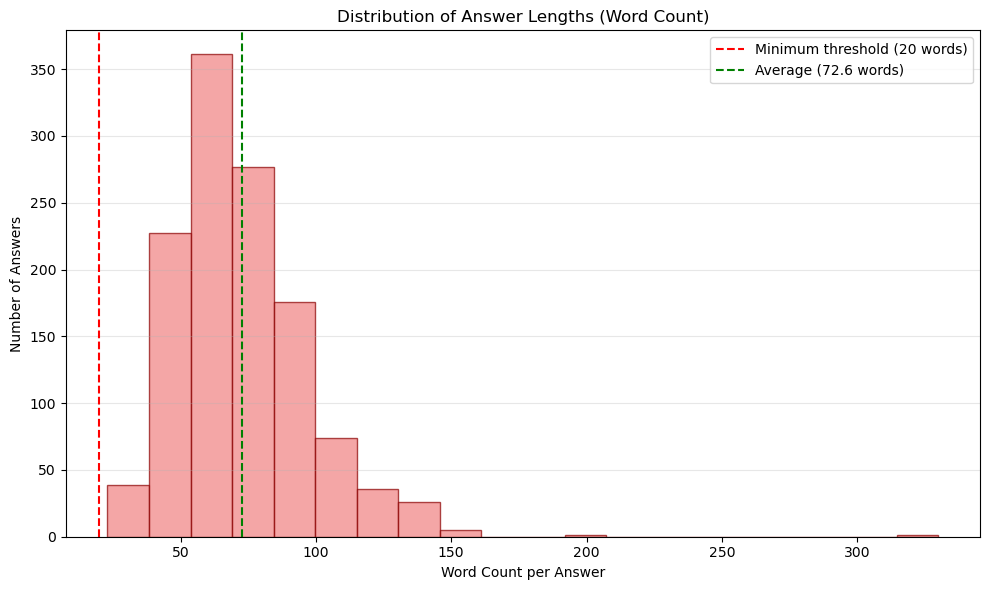

In [19]:
print("=" * 60)
print("RUNNING QC CHECKS AND DATA CLEANING")
print("=" * 60)

# Step 1: Initial QC to identify issues
print("\n1️⃣ INITIAL QUALITY CHECKS")
empty_results = check_empty_answers(combined_data)
duplicate_results = check_duplicate_questions(combined_data)
format_results = check_json_format(combined_data)

# Step 2: Clean the data based on QC results
print("\n2️⃣ DATA CLEANING")
combined_data = remove_empty_answers(combined_data, empty_results)
combined_data = merge_duplicate_questions(combined_data, duplicate_results)

# Step 3: Reassign IDs after cleaning
print("\n3️⃣ REASSIGNING IDS AFTER CLEANING")
reassign_question_ids(combined_data)

# Step 4: Final QC checks on cleaned data
print("\n4️⃣ FINAL QUALITY CHECKS")
coverage_results = check_questions_coverage(combined_data)
answer_dist_results = analyze_answer_distribution(combined_data)
length_results = analyze_answer_lengths(combined_data)

# Verification that cleaning worked
final_empty_results = check_empty_answers(combined_data)
final_duplicate_results = check_duplicate_questions(combined_data)

print("\n📊 VISUALIZATIONS")
visualize_answer_distribution(answer_dist_results)
visualize_answer_lengths(length_results)

In [20]:
# Save comprehensive QC report
save_qc_report(coverage_results, answer_dist_results, length_results,
               duplicate_results, empty_results, format_results)

✅ QC report saved to: ada_qa_qc_report_20250603_214444.txt


'ada_qa_qc_report_20250603_214444.txt'

In [23]:
print("\n" + "=" * 60)
print("SAVING CLEANED DATA")
print("=" * 60)

def assess_data_quality(coverage_results, length_results, final_empty_results, final_duplicate_results):
    """Assess if data quality is acceptable for saving"""
    issues = []
    warnings = []
    
    # Critical issues (should block save)
    if final_empty_results["empty_answers_found"]:
        issues.append(f"Still has {final_empty_results['count']} questions with no answers")
    
    if final_duplicate_results["duplicates_found"]:
        issues.append(f"Still has {len(final_duplicate_results['duplicate_questions'])} duplicate questions")
    
    # Warnings (noteworthy but not blocking)
    if coverage_results["coverage_rate"] < 0.5:  # Less than 50% coverage
        warnings.append(f"Low question coverage: {coverage_results['coverage_rate']*100:.1f}%")
    
    if length_results["short_answers_count"] > len(combined_data) * 0.1:  # More than 10% short
        warnings.append(f"Many short answers: {length_results['short_answers_count']} ({length_results['short_answers_count']/length_results['total_answers']*100:.1f}%)")
    
    return issues, warnings

# Assess data quality
issues, warnings = assess_data_quality(coverage_results, length_results, final_empty_results, final_duplicate_results)

# Display assessment
if issues:
    print("❌ CRITICAL ISSUES FOUND:")
    for issue in issues:
        print(f"   • {issue}")
    
    # Allow override for critical issues
    override = input(f"\n🤔 Save anyway despite critical issues? (y/N): ").lower().strip()
    
    if override == 'y' or override == 'yes':
        print("⚠️  OVERRIDE: Saving data despite critical issues")
        save_data = True
        save_suffix = "OVERRIDE_"
    else:
        print("🚫 Data NOT saved due to critical issues")
        save_data = False
        
elif warnings:
    print("⚠️  WARNINGS (non-critical):")
    for warning in warnings:
        print(f"   • {warning}")
    print(f"\n✅ Data quality acceptable despite warnings")
    save_data = True
    save_suffix = "warnings_"
    
else:
    print("✅ EXCELLENT DATA QUALITY - No issues or warnings found!")
    save_data = True
    save_suffix = ""

# Save if approved
if save_data:
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_file = f"generated_qa_pairs_combined_clean_{save_suffix}{timestamp}.json"
    with open(output_file, 'w') as outfile:
        json.dump(combined_data, outfile, indent=2)
    print(f"💾 Clean data saved to: {output_file}")
    
    print(f"\nFinal dataset: {len(combined_data)} questions, {sum(len(qa['answers']) for qa in combined_data)} total answers")
else:
    print(f"\nDataset not saved: {len(combined_data)} questions, {sum(len(qa['answers']) for qa in combined_data)} total answers")


SAVING CLEANED DATA
✅ EXCELLENT DATA QUALITY - No issues or warnings found!
💾 Clean data saved to: generated_qa_pairs_combined_clean_20250603_214922.json

Final dataset: 432 questions, 1223 total answers
